In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.metrics import classification_report

In [2]:
# Importing the dataset:
dataset = pd.read_csv('../DATA/breast-cancer-wisconsin-data.csv')      

# Removing unwanted columns
unwanted_features = ['Unnamed: 0', 'id']
dataset.drop(unwanted_features, axis=1,inplace=True)
dataset.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


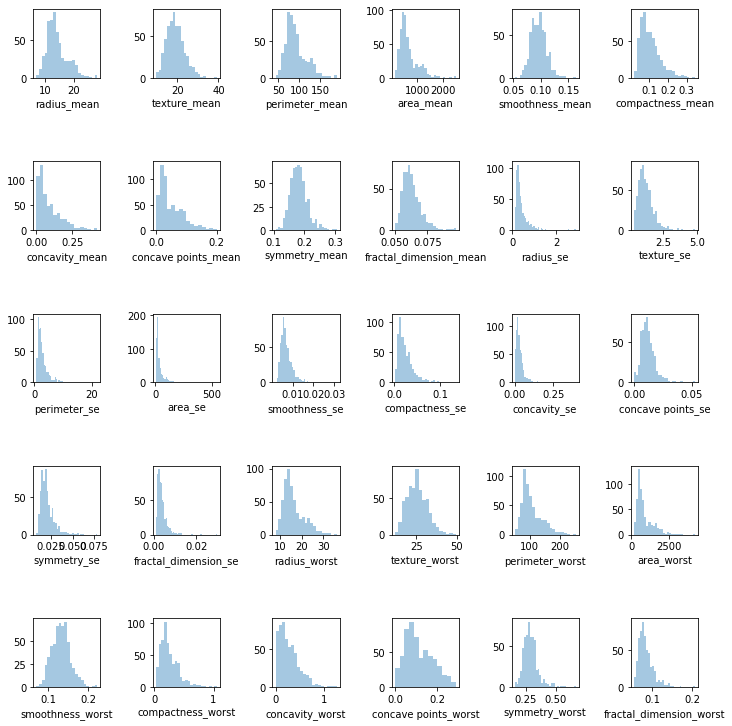

In [3]:
dataset['diagnosis'] = dataset['diagnosis'].astype('category')
dataset['diagnosis'] = dataset['diagnosis'].cat.codes

features = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean',
            'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 
            'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se',
            'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se',
            'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst',
            'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst',
            'concavity_worst', 'concave points_worst', 'symmetry_worst', 
            'fractal_dimension_worst']

fig, axs = plt.subplots(ncols=6, nrows=5, figsize=(10, 10))
index = 0
axs = axs.flatten()
for k,v in dataset[features].items():
    sns.distplot(v, ax=axs[index], kde=False)
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [4]:
X = dataset[features].values
y = dataset['diagnosis'].values

# Splitting the data set into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the input variables
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X=X_train)
X_test = sc_X.transform(X_test)

In [5]:
def model_validation(val_y, val_prediction):
    ll = log_loss(y_true=val_y,y_pred=val_prediction)
    cm = confusion_matrix(y_true=val_y,y_pred=val_prediction)
    accuracy = sum(np.diag(cm))/sum(sum(cm))
    return (ll, cm, accuracy)

def plot_result(X_train, y_train, X_test, y_test, classifier, title):
    # Visualising the Training set results
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    X_set, y_set = X_train, y_train
    X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                         np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
    plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
                 alpha = 0.5, cmap = ListedColormap(('red', 'green')))
    plt.xlim(X1.min(), X1.max())
    plt.ylim(X2.min(), X2.max())
    for i, j in enumerate(np.unique(y_set)):
        plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                    c = ListedColormap(('red', 'green'))(i), label = j)
    plt.title(title + '(Training set)')
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.legend()
        
    plt.subplot(1,2,2)
    X_set, y_set = X_test, y_test
    X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                         np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
    plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
                 alpha = 0.5, cmap = ListedColormap(('red', 'green')))
    plt.xlim(X1.min(), X1.max())
    plt.ylim(X2.min(), X2.max())
    for i, j in enumerate(np.unique(y_set)):
        plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                    c = ListedColormap(('red', 'green'))(i), label = j)
    plt.title(title + '(Testing set)')
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.legend()
    plt.show()

classifiers = ['Logistic Regression', 'Decision Tree classifier', 
               'Random Forest classifier', 'K Nearest Neighbour classifier'] 

In [6]:
def model_LogisticRegression(X_train, y_train, X_test, y_test):    
    print('\nLogistic Regression: ')
    classifier = LogisticRegression(random_state=0)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    print(classification_report(y_test, y_pred))
    if (X_train.shape[1]==2):
        plot_result(X_train, y_train, X_test, y_test, classifier, 'Logistic Regression')
    return model_validation(y_test, y_pred)    
    
def model_DecisionTreeClassifier(X_train, y_train, X_test, y_test):    
    print('\nDecission Tree classifier: ')
    classifier = DecisionTreeClassifier(random_state=42)
    classifier.fit(X=X_train, y=y_train)
    y_pred = classifier.predict(X_test)
    print(classification_report(y_test, y_pred))
    if (X_train.shape[1]==2):
        plot_result(X_train, y_train, X_test, y_test, classifier, 'Decission Tree classifier')
    return model_validation(y_test, y_pred)

def model_RandomForestClassifier(X_train, y_train, X_test, y_test):    
    print('\nRandom Forest classifier: ')
    classifier = RandomForestClassifier(random_state=42)
    classifier.fit(X=X_train, y=y_train)
    y_pred = classifier.predict(X_test)
    print(classification_report(y_test, y_pred))
    if (X_train.shape[1]==2):
        plot_result(X_train, y_train, X_test, y_test, classifier, 'Random Forest classifier')
    return model_validation(y_test, y_pred)

def model_KNeighborsClassifier(X_train, y_train, X_test, y_test):    
    print('\nK-nearest neighbor classifier: ')
    classifier = KNeighborsClassifier(n_neighbors=4)
    classifier.fit(X=X_train, y=y_train)
    y_pred = classifier.predict(X_test)
    print(classification_report(y_test, y_pred))
    if (X_train.shape[1]==2):
        plot_result(X_train, y_train, X_test, y_test, classifier, 'K-nearest neighbor classifier')
    return model_validation(y_test, y_pred)


In [7]:
def model_classifier(X_train, y_train, X_test, y_test):      
    
    logLosses, confusionMatrices, accuracies = [], [], []
    (ll, cm, accuracy) = model_LogisticRegression(X_train, y_train, X_test, y_test)
    logLosses.append(ll)
    confusionMatrices.append(cm)
    accuracies.append(accuracy)    
    
    (ll, cm, accuracy) = model_DecisionTreeClassifier(X_train, y_train, X_test, y_test)
    logLosses.append(ll)
    confusionMatrices.append(cm)
    accuracies.append(accuracy)
    
    (ll, cm, accuracy) = model_RandomForestClassifier(X_train, y_train, X_test, y_test)
    logLosses.append(ll)
    confusionMatrices.append(cm)
    accuracies.append(accuracy)
    
    (ll, cm, accuracy) = model_KNeighborsClassifier(X_train, y_train, X_test, y_test)
    logLosses.append(ll)
    confusionMatrices.append(cm)
    accuracies.append(accuracy)
    
    return (logLosses, confusionMatrices, accuracies)

In [8]:
def principal_component_analysis(X_train, X_test):
    
    pca = PCA(n_components=2)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    return (X_train, X_test)

def linear_discriminatory_analysis(X_train, X_test):
    
    lda = LinearDiscriminantAnalysis(n_components=2)
    X_train = lda.fit_transform(X_train, y_train)
    X_test = lda.transform(X_test)
    return (X_train, X_test)

def dimensionality_reduction(X_train, y_train, X_test, y_test):
    
    logLosses, confusionMatrices, accuracies = [], [], []
    (X_train, X_test) = principal_component_analysis(X_train, X_test)
    (logLosses_pca, confusionMatrices_pca, accuracies_pca) = model_classifier(X_train, y_train, X_test, y_test)
    logLosses.append(logLosses_pca)
    confusionMatrices.append(confusionMatrices_pca)
    accuracies.append(accuracies_pca)
    
    (X_train, X_test) = linear_discriminatory_analysis(X_train, X_test)
    (logLosses_lda, confusionMatrices_lda, accuracies_lda) = model_classifier(X_train, y_train, X_test, y_test)
    logLosses.append(logLosses_lda)
    confusionMatrices.append(confusionMatrices_lda)
    accuracies.append(accuracies_lda)
    
    return (logLosses, confusionMatrices, accuracies)

In [9]:
# Analysis with all the features
(logLosses, confusionMatrices, accuracies) = model_classifier(X_train, y_train, X_test, y_test)
accuracy = pd.DataFrame(accuracies, index = classifiers, columns=['Without Dimensionality Reduction'])
accuracy.head()


Logistic Regression: 
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        71
           1       0.98      0.95      0.96        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114


Decission Tree classifier: 
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        71
           1       0.93      0.93      0.93        43

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114


Random Forest classifier: 
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        71
           1       0.98      0.93      0.95        43

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96     

,Without Dimensionality Reduction
Logistic Regression,0.973684
Decision Tree classifier,0.947368
Random Forest classifier,0.964912
K Nearest Neighbour classifier,0.956140



Logistic Regression: 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        71
           1       1.00      0.98      0.99        43

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114



'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

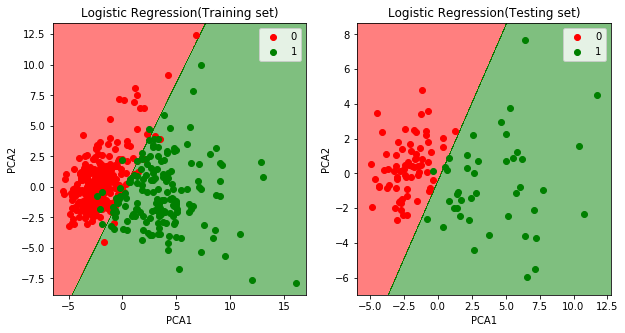


Decission Tree classifier: 
              precision    recall  f1-score   support

           0       0.97      0.96      0.96        71
           1       0.93      0.95      0.94        43

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114



'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

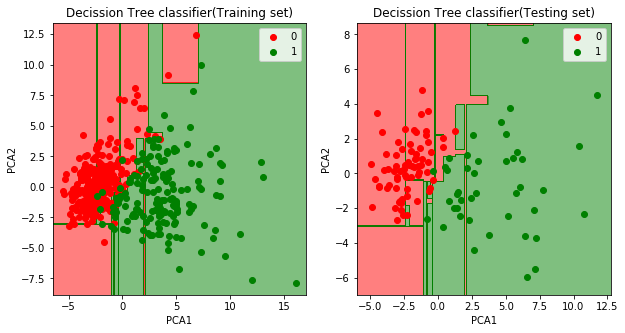


Random Forest classifier: 
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        71
           1       1.00      0.95      0.98        43

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

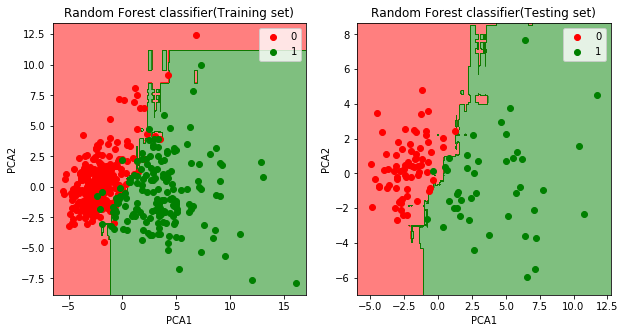


K-nearest neighbor classifier: 
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        71
           1       1.00      0.93      0.96        43

    accuracy                           0.97       114
   macro avg       0.98      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

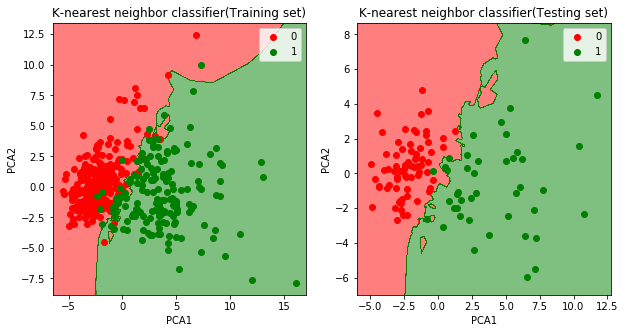


Logistic Regression: 
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        71
           1       1.00      0.93      0.96        43

    accuracy                           0.97       114
   macro avg       0.98      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114


Decission Tree classifier: 
              precision    recall  f1-score   support

           0       0.93      0.89      0.91        71
           1       0.83      0.88      0.85        43

    accuracy                           0.89       114
   macro avg       0.88      0.89      0.88       114
weighted avg       0.89      0.89      0.89       114


Random Forest classifier: 
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        71
           1       0.88      0.88      0.88        43

    accuracy                           0.91       114
   macro avg       0.91      0.91      0.91     

,Without Dimensionality Reduction,After PCA,After LDA
Logistic Regression,0.973684,0.991228,0.973684
Decision Tree classifier,0.947368,0.956140,0.885965
Random Forest classifier,0.964912,0.982456,0.912281
K Nearest Neighbour classifier,0.956140,0.973684,0.956140


In [10]:
# Analysis done after reducung to two dimensions 
(logLosses_DR, confusionMatrices_DR, accuracies_DR) = dimensionality_reduction(X_train, y_train, X_test, y_test)
accuracy.insert(loc=1, column='After PCA', value = accuracies_DR[0])
accuracy.insert(loc=2, column='After LDA', value = accuracies_DR[1])
accuracy.head()

### Buliding the Neural Network

In [16]:
# Importing the Keras libraries and packages required to build the artificial neural network (ANN)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

classifier = Sequential()
classifier.add(Dense(units=2, kernel_initializer='uniform', activation='relu', input_dim=X_train.shape[1]))
classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) 
history = classifier.fit(X_train,y_train, batch_size=128, validation_data = (X_test, y_test), epochs=200, verbose=2)

Train on 455 samples, validate on 114 samples
Epoch 1/200
455/455 - 1s - loss: 0.6926 - accuracy: 0.6286 - val_loss: 0.6919 - val_accuracy: 0.6228
Epoch 2/200
455/455 - 0s - loss: 0.6908 - accuracy: 0.6286 - val_loss: 0.6902 - val_accuracy: 0.6228
Epoch 3/200
455/455 - 0s - loss: 0.6891 - accuracy: 0.6286 - val_loss: 0.6883 - val_accuracy: 0.6228
Epoch 4/200
455/455 - 0s - loss: 0.6870 - accuracy: 0.6286 - val_loss: 0.6862 - val_accuracy: 0.6228
Epoch 5/200
455/455 - 0s - loss: 0.6848 - accuracy: 0.6286 - val_loss: 0.6838 - val_accuracy: 0.6228
Epoch 6/200
455/455 - 0s - loss: 0.6822 - accuracy: 0.6286 - val_loss: 0.6811 - val_accuracy: 0.6228
Epoch 7/200
455/455 - 0s - loss: 0.6793 - accuracy: 0.6286 - val_loss: 0.6780 - val_accuracy: 0.6228
Epoch 8/200
455/455 - 0s - loss: 0.6761 - accuracy: 0.6286 - val_loss: 0.6746 - val_accuracy: 0.6228
Epoch 9/200
455/455 - 0s - loss: 0.6725 - accuracy: 0.6286 - val_loss: 0.6709 - val_accuracy: 0.6228
Epoch 10/200
455/455 - 0s - loss: 0.6684 - ac

Epoch 81/200
455/455 - 0s - loss: 0.3568 - accuracy: 0.9407 - val_loss: 0.3363 - val_accuracy: 0.9649
Epoch 82/200
455/455 - 0s - loss: 0.3549 - accuracy: 0.9407 - val_loss: 0.3344 - val_accuracy: 0.9649
Epoch 83/200
455/455 - 0s - loss: 0.3531 - accuracy: 0.9407 - val_loss: 0.3326 - val_accuracy: 0.9737
Epoch 84/200
455/455 - 0s - loss: 0.3513 - accuracy: 0.9407 - val_loss: 0.3308 - val_accuracy: 0.9737
Epoch 85/200
455/455 - 0s - loss: 0.3495 - accuracy: 0.9407 - val_loss: 0.3291 - val_accuracy: 0.9737
Epoch 86/200
455/455 - 0s - loss: 0.3477 - accuracy: 0.9473 - val_loss: 0.3273 - val_accuracy: 0.9737
Epoch 87/200
455/455 - 0s - loss: 0.3460 - accuracy: 0.9473 - val_loss: 0.3257 - val_accuracy: 0.9737
Epoch 88/200
455/455 - 0s - loss: 0.3443 - accuracy: 0.9473 - val_loss: 0.3239 - val_accuracy: 0.9737
Epoch 89/200
455/455 - 0s - loss: 0.3426 - accuracy: 0.9473 - val_loss: 0.3223 - val_accuracy: 0.9737
Epoch 90/200
455/455 - 0s - loss: 0.3409 - accuracy: 0.9495 - val_loss: 0.3207 - v

Epoch 161/200
455/455 - 0s - loss: 0.2513 - accuracy: 0.9824 - val_loss: 0.2419 - val_accuracy: 0.9825
Epoch 162/200
455/455 - 0s - loss: 0.2504 - accuracy: 0.9824 - val_loss: 0.2411 - val_accuracy: 0.9825
Epoch 163/200
455/455 - 0s - loss: 0.2496 - accuracy: 0.9824 - val_loss: 0.2404 - val_accuracy: 0.9825
Epoch 164/200
455/455 - 0s - loss: 0.2487 - accuracy: 0.9824 - val_loss: 0.2396 - val_accuracy: 0.9825
Epoch 165/200
455/455 - 0s - loss: 0.2479 - accuracy: 0.9824 - val_loss: 0.2388 - val_accuracy: 0.9825
Epoch 166/200
455/455 - 0s - loss: 0.2470 - accuracy: 0.9824 - val_loss: 0.2380 - val_accuracy: 0.9825
Epoch 167/200
455/455 - 0s - loss: 0.2462 - accuracy: 0.9824 - val_loss: 0.2372 - val_accuracy: 0.9825
Epoch 168/200
455/455 - 0s - loss: 0.2454 - accuracy: 0.9824 - val_loss: 0.2363 - val_accuracy: 0.9825
Epoch 169/200
455/455 - 0s - loss: 0.2445 - accuracy: 0.9824 - val_loss: 0.2355 - val_accuracy: 0.9825
Epoch 170/200
455/455 - 0s - loss: 0.2437 - accuracy: 0.9824 - val_loss: 

In [17]:
y_pred = classifier.predict(X_test) 
y_pred = y_pred>0.5

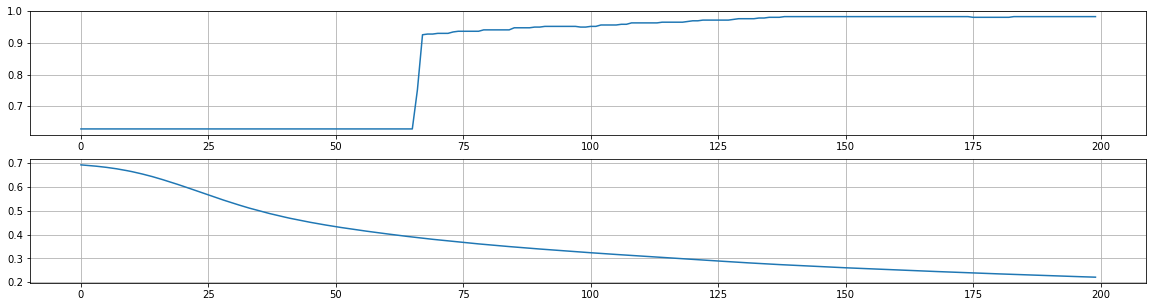

In [18]:
plt.figure(figsize=(20,5))
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.grid()
plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.grid()

In [19]:
(ll, cm, accuracy) = model_validation(y_test, y_pred)

In [20]:
(ll, cm, accuracy)

(0.6059504595372953,
 array([[70,  1],
        [ 1, 42]]),
 0.9824561403508771)